In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
import gc  # Garbage collector for memory cleanup
import os
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from tqdm import tqdm
from google.colab import drive
from matplotlib import pyplot as plt
import pandas as pd
import glob
from PIL import Image
matplotlib.style.use('ggplot')

In [2]:
!mkdir input

In [3]:
drive.mount('/content/drive')
output_dir = "/content/drive/MyDrive/GAN_outputs"
os.makedirs(output_dir, exist_ok=True)


Mounted at /content/drive


In [4]:
# learning parameters
batch_size = 128
epochs = 300
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator

In [5]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

to_pil_image = transforms.ToPILImage()

In [6]:
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
#train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
#save ram
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 37.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.18MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.99MB/s]


In [7]:
torch.cuda.empty_cache()
gc.collect()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

# Initialize models
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

# Optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

# Loss function
criterion = nn.BCELoss()

# Labels
def label_real(size):
    return torch.ones(size, 1, device=device)

def label_fake(size):
    return torch.zeros(size, 1, device=device)

# Create noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz, device=device)

# Save images
def save_generator_image(image, path):
    save_image(image, path)

# Train Discriminator
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)

    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)

    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)

    loss_real.backward()
    loss_fake.backward()
    optimizer.step()

    return loss_real + loss_fake

# Train Generator
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)

    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)

    loss.backward()
    optimizer.step()

    return loss

# Checkpoint path
checkpoint_path = f"{output_dir}/generator_checkpoint.pth"

# Load checkpoint if it exists
start_epoch = 0
if os.path.exists(checkpoint_path):
    generator.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
 #   generator.load_state_dict(torch.load(checkpoint_path))
    start_epoch = 241  # Resume from epoch 270
    print(f"✅ Resuming training from epoch {start_epoch}")

# Create noise vector
noise = create_noise(sample_size, nz)

# Training Loop
generator.train()
discriminator.train()

losses_g, losses_d, images = [], [], []
'''
for epoch in range(start_epoch, epochs):
    loss_g, loss_d = 0.0, 0.0
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)

        # Train Discriminator
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            loss_d += train_discriminator(optim_d, image, data_fake)

        # Train Generator
        data_fake = generator(create_noise(b_size, nz))
        loss_g += train_generator(optim_g, data_fake)

    # Generate sample image (only save every 10 epochs)
    if epoch % 10 == 0:
        with torch.no_grad():
            generated_img = generator(noise).cpu()
        generated_img = make_grid(generated_img, normalize=True)
        save_generator_image(generated_img, f"{output_dir}/gen_img{epoch}.png")
        images.append(generated_img)

    # Compute and store losses
    epoch_loss_g = loss_g / len(train_loader)
    epoch_loss_d = loss_d / len(train_loader)
    losses_g.append(epoch_loss_g.cpu().item())
    losses_d.append(epoch_loss_d.cpu().item())

    print(f"Epoch {epoch} of {epochs} | Generator loss: {epoch_loss_g:.8f} | Discriminator loss: {epoch_loss_d:.8f}")

    # Save model checkpoint every 50 epochs
    if epoch % 50 == 0:
        torch.save(generator.state_dict(), checkpoint_path)
        print(f"✅ Checkpoint saved at epoch {epoch}")

    # Free memory
    torch.cuda.empty_cache()
    gc.collect()
'''
# Load existing loss file if available (resuming from checkpoint)
loss_csv_path = f"{output_dir}/losses.csv"
if os.path.exists(loss_csv_path):
    loss_df = pd.read_csv(loss_csv_path)
    losses_g = loss_df["generator_loss"].tolist()
    losses_d = loss_df["discriminator_loss"].tolist()
    start_epoch = len(losses_g)  # Resume from the last saved epoch
    print(f"✅ Resuming training from epoch {start_epoch}")
else:
    losses_g, losses_d = [], []  # Start fresh if no saved loss file

for epoch in range(start_epoch, epochs):
    loss_g, loss_d = 0.0, 0.0
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)

        # Train Discriminator
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            loss_d += train_discriminator(optim_d, image, data_fake)

        # Train Generator
        data_fake = generator(create_noise(b_size, nz))
        loss_g += train_generator(optim_g, data_fake)

    # Generate sample image (only save every 10 epochs)
    if epoch % 10 == 0:
        with torch.no_grad():
            generated_img = generator(noise).cpu()
        generated_img = make_grid(generated_img, normalize=True)
        save_generator_image(generated_img, f"{output_dir}/gen_img{epoch}.png")
        images.append(generated_img)

    # Compute average loss for the epoch
    epoch_loss_g = loss_g / len(train_loader)
    epoch_loss_d = loss_d / len(train_loader)
    losses_g.append(epoch_loss_g.cpu().item())
    losses_d.append(epoch_loss_d.cpu().item())

    print(f"Epoch {epoch} of {epochs} | Generator loss: {epoch_loss_g:.8f} | Discriminator loss: {epoch_loss_d:.8f}")

    # ✅ Save updated loss values after every epoch
    loss_df = pd.DataFrame({
        "epoch": list(range(len(losses_g))),
        "generator_loss": losses_g,
        "discriminator_loss": losses_d
    })
    loss_df.to_csv(loss_csv_path, index=False)

    print("✅ Loss values saved!")

    # Save model checkpoint every 30 epochs
    if epoch % 30 == 0:
        torch.save(generator.state_dict(), checkpoint_path)
        print(f"✅ Checkpoint saved at epoch {epoch}")

    # Free memory
    torch.cuda.empty_cache()
    gc.collect()

print("🎉 Training Completed!")

# Final Model Save
torch.save(generator.state_dict(), f"{output_dir}/generator_final.pth")



✅ Resuming training from epoch 241
✅ Resuming training from epoch 245


100%|██████████| 469/469 [01:10<00:00,  6.69it/s]


Epoch 245 of 300 | Generator loss: 0.76102710 | Discriminator loss: 1.34691250
✅ Loss values saved!


100%|██████████| 469/469 [01:09<00:00,  6.75it/s]


Epoch 246 of 300 | Generator loss: 0.80171114 | Discriminator loss: 1.31732547
✅ Loss values saved!


100%|██████████| 469/469 [01:09<00:00,  6.73it/s]


Epoch 247 of 300 | Generator loss: 0.78589332 | Discriminator loss: 1.32349956
✅ Loss values saved!


100%|██████████| 469/469 [01:12<00:00,  6.43it/s]


Epoch 248 of 300 | Generator loss: 0.77993602 | Discriminator loss: 1.33185077
✅ Loss values saved!


100%|██████████| 469/469 [01:11<00:00,  6.56it/s]


Epoch 249 of 300 | Generator loss: 0.78385806 | Discriminator loss: 1.33048391
✅ Loss values saved!


100%|██████████| 469/469 [01:13<00:00,  6.37it/s]


Epoch 250 of 300 | Generator loss: 0.77488232 | Discriminator loss: 1.33740616
✅ Loss values saved!


100%|██████████| 469/469 [01:12<00:00,  6.45it/s]


Epoch 251 of 300 | Generator loss: 0.77419692 | Discriminator loss: 1.33608663
✅ Loss values saved!


100%|██████████| 469/469 [01:12<00:00,  6.49it/s]


Epoch 252 of 300 | Generator loss: 0.78561407 | Discriminator loss: 1.32755816
✅ Loss values saved!


100%|██████████| 469/469 [01:11<00:00,  6.57it/s]


Epoch 253 of 300 | Generator loss: 0.79148769 | Discriminator loss: 1.32219136
✅ Loss values saved!


100%|██████████| 469/469 [01:11<00:00,  6.58it/s]


Epoch 254 of 300 | Generator loss: 0.79966682 | Discriminator loss: 1.32057488
✅ Loss values saved!


100%|██████████| 469/469 [01:12<00:00,  6.46it/s]


Epoch 255 of 300 | Generator loss: 0.79305482 | Discriminator loss: 1.32388103
✅ Loss values saved!


100%|██████████| 469/469 [01:10<00:00,  6.62it/s]


Epoch 256 of 300 | Generator loss: 0.79710478 | Discriminator loss: 1.31591940
✅ Loss values saved!


100%|██████████| 469/469 [01:14<00:00,  6.26it/s]


Epoch 257 of 300 | Generator loss: 0.79126090 | Discriminator loss: 1.32501817
✅ Loss values saved!


100%|██████████| 469/469 [01:13<00:00,  6.36it/s]


Epoch 258 of 300 | Generator loss: 0.78464901 | Discriminator loss: 1.32692480
✅ Loss values saved!


100%|██████████| 469/469 [01:15<00:00,  6.20it/s]


Epoch 259 of 300 | Generator loss: 0.79477680 | Discriminator loss: 1.32050884
✅ Loss values saved!


100%|██████████| 469/469 [01:15<00:00,  6.22it/s]


Epoch 260 of 300 | Generator loss: 0.80556315 | Discriminator loss: 1.31529176
✅ Loss values saved!


100%|██████████| 469/469 [01:13<00:00,  6.37it/s]


Epoch 261 of 300 | Generator loss: 0.79758948 | Discriminator loss: 1.31723690
✅ Loss values saved!


100%|██████████| 469/469 [01:16<00:00,  6.16it/s]


Epoch 262 of 300 | Generator loss: 0.81047678 | Discriminator loss: 1.30985332
✅ Loss values saved!


100%|██████████| 469/469 [01:14<00:00,  6.29it/s]


Epoch 263 of 300 | Generator loss: 0.81210029 | Discriminator loss: 1.30786479
✅ Loss values saved!


100%|██████████| 469/469 [01:15<00:00,  6.25it/s]


Epoch 264 of 300 | Generator loss: 0.81779963 | Discriminator loss: 1.30691326
✅ Loss values saved!


100%|██████████| 469/469 [01:15<00:00,  6.18it/s]


Epoch 265 of 300 | Generator loss: 0.81811613 | Discriminator loss: 1.30325651
✅ Loss values saved!


100%|██████████| 469/469 [01:14<00:00,  6.31it/s]


Epoch 266 of 300 | Generator loss: 0.80795830 | Discriminator loss: 1.31334972
✅ Loss values saved!


100%|██████████| 469/469 [01:13<00:00,  6.37it/s]


Epoch 267 of 300 | Generator loss: 0.81197685 | Discriminator loss: 1.31222939
✅ Loss values saved!


100%|██████████| 469/469 [01:12<00:00,  6.44it/s]


Epoch 268 of 300 | Generator loss: 0.81544375 | Discriminator loss: 1.30705953
✅ Loss values saved!


100%|██████████| 469/469 [01:13<00:00,  6.40it/s]


Epoch 269 of 300 | Generator loss: 0.80242896 | Discriminator loss: 1.31612432
✅ Loss values saved!


100%|██████████| 469/469 [01:13<00:00,  6.35it/s]


Epoch 270 of 300 | Generator loss: 0.79447585 | Discriminator loss: 1.32205379
✅ Loss values saved!
✅ Checkpoint saved at epoch 270


100%|██████████| 469/469 [01:13<00:00,  6.38it/s]


Epoch 271 of 300 | Generator loss: 0.78967232 | Discriminator loss: 1.32462037
✅ Loss values saved!


100%|██████████| 469/469 [01:13<00:00,  6.36it/s]


Epoch 272 of 300 | Generator loss: 0.79432803 | Discriminator loss: 1.32462418
✅ Loss values saved!


100%|██████████| 469/469 [01:14<00:00,  6.30it/s]


Epoch 273 of 300 | Generator loss: 0.78392828 | Discriminator loss: 1.32754457
✅ Loss values saved!


100%|██████████| 469/469 [01:14<00:00,  6.29it/s]


Epoch 274 of 300 | Generator loss: 0.78716069 | Discriminator loss: 1.32806206
✅ Loss values saved!


100%|██████████| 469/469 [01:12<00:00,  6.45it/s]


Epoch 275 of 300 | Generator loss: 0.78567332 | Discriminator loss: 1.32743418
✅ Loss values saved!


100%|██████████| 469/469 [01:14<00:00,  6.29it/s]


Epoch 276 of 300 | Generator loss: 0.79321671 | Discriminator loss: 1.32454181
✅ Loss values saved!


100%|██████████| 469/469 [01:13<00:00,  6.36it/s]


Epoch 277 of 300 | Generator loss: 0.78275329 | Discriminator loss: 1.32674837
✅ Loss values saved!


100%|██████████| 469/469 [01:14<00:00,  6.32it/s]


Epoch 278 of 300 | Generator loss: 0.78672022 | Discriminator loss: 1.33031857
✅ Loss values saved!


100%|██████████| 469/469 [01:13<00:00,  6.40it/s]


Epoch 279 of 300 | Generator loss: 0.78213489 | Discriminator loss: 1.32981205
✅ Loss values saved!


100%|██████████| 469/469 [01:14<00:00,  6.31it/s]


Epoch 280 of 300 | Generator loss: 0.77811694 | Discriminator loss: 1.33035803
✅ Loss values saved!


100%|██████████| 469/469 [01:14<00:00,  6.28it/s]


Epoch 281 of 300 | Generator loss: 0.77929664 | Discriminator loss: 1.33403111
✅ Loss values saved!


100%|██████████| 469/469 [01:14<00:00,  6.32it/s]


Epoch 282 of 300 | Generator loss: 0.77753162 | Discriminator loss: 1.33250904
✅ Loss values saved!


100%|██████████| 469/469 [01:15<00:00,  6.23it/s]


Epoch 283 of 300 | Generator loss: 0.77680504 | Discriminator loss: 1.33803856
✅ Loss values saved!


100%|██████████| 469/469 [01:14<00:00,  6.31it/s]


Epoch 284 of 300 | Generator loss: 0.77793354 | Discriminator loss: 1.33071220
✅ Loss values saved!


100%|██████████| 469/469 [01:13<00:00,  6.40it/s]


Epoch 285 of 300 | Generator loss: 0.78175378 | Discriminator loss: 1.33292377
✅ Loss values saved!


100%|██████████| 469/469 [01:12<00:00,  6.44it/s]


Epoch 286 of 300 | Generator loss: 0.77574623 | Discriminator loss: 1.33437455
✅ Loss values saved!


100%|██████████| 469/469 [01:14<00:00,  6.31it/s]


Epoch 287 of 300 | Generator loss: 0.78092593 | Discriminator loss: 1.33044374
✅ Loss values saved!


100%|██████████| 469/469 [01:14<00:00,  6.26it/s]


Epoch 288 of 300 | Generator loss: 0.78125119 | Discriminator loss: 1.33266997
✅ Loss values saved!


100%|██████████| 469/469 [01:15<00:00,  6.22it/s]


Epoch 289 of 300 | Generator loss: 0.77503449 | Discriminator loss: 1.33360302
✅ Loss values saved!


100%|██████████| 469/469 [01:13<00:00,  6.42it/s]


Epoch 290 of 300 | Generator loss: 0.78408432 | Discriminator loss: 1.33317578
✅ Loss values saved!


100%|██████████| 469/469 [01:12<00:00,  6.45it/s]


Epoch 291 of 300 | Generator loss: 0.77832770 | Discriminator loss: 1.33219004
✅ Loss values saved!


100%|██████████| 469/469 [01:16<00:00,  6.17it/s]


Epoch 292 of 300 | Generator loss: 0.78336775 | Discriminator loss: 1.32824564
✅ Loss values saved!


100%|██████████| 469/469 [01:11<00:00,  6.52it/s]


Epoch 293 of 300 | Generator loss: 0.78662342 | Discriminator loss: 1.32449591
✅ Loss values saved!


100%|██████████| 469/469 [01:12<00:00,  6.43it/s]


Epoch 294 of 300 | Generator loss: 0.79019558 | Discriminator loss: 1.32340944
✅ Loss values saved!


100%|██████████| 469/469 [01:14<00:00,  6.34it/s]


Epoch 295 of 300 | Generator loss: 0.78896856 | Discriminator loss: 1.32618153
✅ Loss values saved!


100%|██████████| 469/469 [01:14<00:00,  6.28it/s]


Epoch 296 of 300 | Generator loss: 0.78283399 | Discriminator loss: 1.33200407
✅ Loss values saved!


100%|██████████| 469/469 [01:13<00:00,  6.39it/s]


Epoch 297 of 300 | Generator loss: 0.77957517 | Discriminator loss: 1.32995093
✅ Loss values saved!


100%|██████████| 469/469 [01:14<00:00,  6.27it/s]


Epoch 298 of 300 | Generator loss: 0.77625877 | Discriminator loss: 1.33679652
✅ Loss values saved!


100%|██████████| 469/469 [01:14<00:00,  6.29it/s]


Epoch 299 of 300 | Generator loss: 0.77362430 | Discriminator loss: 1.33509576
✅ Loss values saved!
🎉 Training Completed!


In [12]:
# Get all saved images from the directory (sorted by epoch number)
image_files = sorted(glob.glob(f"{output_dir}/gen_img*.png"))

# Load images into a list
imgs = [np.array(Image.open(img_file)) for img_file in image_files]

# Create and save the GIF
imageio.mimsave(f"{output_dir}/generator_images.gif", imgs, duration=5)  # Adjust duration for speed

print(f"🎉 GIF created with {len(imgs)} images!")

🎉 GIF created with 30 images!


✅ Loss data loaded successfully!
🎉 Loss plot regenerated!


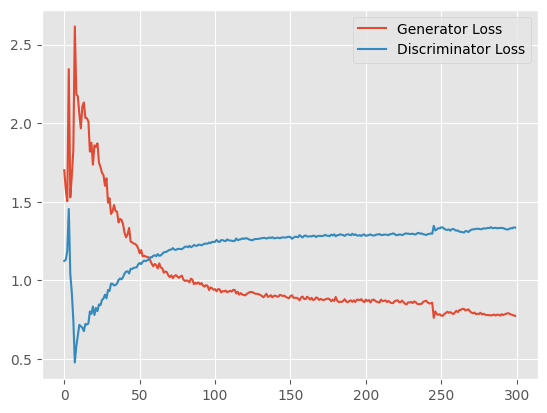

In [11]:
loss_csv_path = f"{output_dir}/losses.csv"

if os.path.exists(loss_csv_path):
    loss_df = pd.read_csv(loss_csv_path)
    losses_g = loss_df["generator_loss"].tolist()
    losses_d = loss_df["discriminator_loss"].tolist()
    print("✅ Loss data loaded successfully!")

    # Recreate and save loss plot
    plt.figure()
    plt.plot(losses_g, label="Generator Loss")
    plt.plot(losses_d, label="Discriminator Loss")
    plt.legend()
    plt.savefig(f"{output_dir}/loss.png")
    print("🎉 Loss plot regenerated!")
else:
    print("⚠️ Loss file not found. Cannot regenerate the plot.")

In [ ]:
# Plot and save loss curves
plt.figure()
plt.plot(losses_g, label="Generator Loss")
plt.plot(losses_d, label="Discriminator Loss")
plt.legend()
plt.savefig(f"{output_dir}/loss.png")